(exploratory-data-analysis)=
# Exploratory Data Analysis

Exploratory data analysis (EDA) involves taking a first look at a dataset and summarising its salient characteristics using tables and graphics. It is (or should be) the stage before testing hypotheses and can be useful in informing hypotheses. In this chapter, we'll look at a few options for EDA using code.

To show how to do EDA using code, we will need a dataset to explore. We'll use the Grinell housing dataset, which covers houses sold between 2005 and 2015 in Grinnell, Iowa. It was assembled by a local estate agent, Matt Karjalahti.

First, let's import a couple of essential packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from itertools import islice
from rich import print

# Plot settings
plt.style.use(
    "https://github.com/aeturrell/coding-for-economists/raw/main/plot_style.txt"
)

## Preliminaries: extracting, typing, and initial cleaning

Let's grab some data to do exploratory data analysis on.

In [2]:
df = pd.read_csv(
    "https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/GrinnellHouses.csv",
    index_col=0,
)
df.head()

Date                  Address  Bedrooms  Baths  SquareFeet   LotSize  \
1  16695     1510 First Ave #112          2    1.0      1120.0       NaN   
2  16880          1020 Center St          3    1.0      1224.0  0.172176   
3  16875       918 Chatterton St          4    1.0      1540.0       NaN   
4  16833  1023 & 1025 Spring St.          3    1.0      1154.0       NaN   
5  16667             503 2nd Ave          3    1.0      1277.0  0.206612   

   YearBuilt  YearSold  MonthSold  DaySold  CostPerSqFt  OrigPrice  ListPrice  \
1       1993      2005          9       16         6.25      17000      10500   
2       1900      2006          3       20        22.06      35000      35000   
3       1970      2006          3       15        18.18      54000      47000   
4       1900      2006          2        1        26.00      65000      49000   
5       1900      2005          8       19        24.08      35000      35000   

   SalePrice  SPLPPct  
1       7000    66.67  
2      27000    77.14  
3      28000    59.57  
4      30000    61.22  
5      30750    87.86

There are some things we should do even before an exploratory data analysis; we should make sure we've cast the columns to the right types and converted any that need converting. Even a quick look at the data provided by `.head()` shows that the `Date` column is in a weird format. It also *seems* like the number of `Baths` column has some data issues because it is a floating point number rather than an integer. However, this a North American quirk: realtors refer to bathrooms with only a toilet and sink as a "half bath" (and sometimes those with a shower but no bathtub as a "three-quarter bath," which also shows up in the data). So this is okay, and we mainly need concern ourselves with the Date column.

Fortunately, there is guidance attached to the dataset as to what the Date column really means: it's just a counter of days that encodes the date of sale that begins with 1st Jan 2005=16436. The documents also tell us that the final year is 2015. We'd really like to have a more usable datetime column than this so let's sort this out first. Ideally, we'd like to *map* the `Date` column into a new `datetime` column that turns 16436 into 1st Jan 2005, 16437 into 2nd Jan 2005, and so on, until we have a mapping for every date between the first date in the dataset and the last. 

Our solution will be to create a function that maps the code for Date into a genuine datetime using the `pd.DateOffset` function and apply it to the `Date` column using `apply`:

In [3]:
def convert_date_code_to_datetime(date):
    start_code = 16436
    return pd.to_datetime("01-01-2005") + pd.DateOffset(days=date - start_code)


df["datetime"] = df["Date"].apply(convert_date_code_to_datetime)
# Check the 'biggest' rows by datetime
df.nlargest(5, columns=["datetime"])

Date          Address  Bedrooms  Baths  SquareFeet    LotSize  \
915  20186   957 350th Ave          3   2.00      1700.0  11.430000   
886  20185   232 4th Ave W          3   2.50         NaN   0.139991   
905  20185  1726 Summer St          4   1.75      1512.0   0.530000   
920  20184     108 East St          4   3.00      1650.0   0.320000   
834  20181  1405 Prince St          3   1.50      1094.0        NaN   

     YearBuilt  YearSold  MonthSold  DaySold  CostPerSqFt  OrigPrice  \
915       1966      2015          4        8       128.82     229000   
886       2004      2015          4        7         0.00     137500   
905       1996      2015          4        7       125.00     239900   
920       2013      2015          4        6       156.97     259000   
834       1900      2015          4        3        18.28      32500   

     ListPrice  SalePrice  SPLPPct   datetime  
915     229000     219000    95.63 2015-04-09  
886     137500     128500    93.45 2015-04-08  
905     219900     189000    85.95 2015-04-08  
920     259000     259000   100.00 2015-04-07  
834      32500      20000    61.54 2015-04-04

An extra column containing datetime has been added and, looking at the max rows, we can see that it does indeed run all the way to 2015 as expected from the documentation of the dataset.

Okay, now we want to sort out the data type isses we saw earlier. But let's just check they're as bad as we think using `df.info()`

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 1 to 929
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         929 non-null    int64         
 1   Address      929 non-null    object        
 2   Bedrooms     929 non-null    int64         
 3   Baths        929 non-null    float64       
 4   SquareFeet   911 non-null    float64       
 5   LotSize      741 non-null    float64       
 6   YearBuilt    929 non-null    int64         
 7   YearSold     929 non-null    int64         
 8   MonthSold    929 non-null    int64         
 9   DaySold      929 non-null    int64         
 10  CostPerSqFt  929 non-null    float64       
 11  OrigPrice    929 non-null    int64         
 12  ListPrice    929 non-null    int64         
 13  SalePrice    929 non-null    int64         
 14  SPLPPct      929 non-null    float64       
 15  datetime     929 non-null    datetime64[ns]
dtypes: datet

**pandas** read most of them in sensibly, but not *all* of them, so let's adjust the ones we need to:

In [5]:
df = df.assign(
    Address=df["Address"].astype("string"),
    Bedrooms=df["Bedrooms"].astype("category"),
    OrigPrice=df["OrigPrice"].astype(float),
    ListPrice=df["ListPrice"].astype(float),
    SalePrice=df["SalePrice"].astype(float),
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 929 entries, 1 to 929
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         929 non-null    int64         
 1   Address      929 non-null    string        
 2   Bedrooms     929 non-null    category      
 3   Baths        929 non-null    float64       
 4   SquareFeet   911 non-null    float64       
 5   LotSize      741 non-null    float64       
 6   YearBuilt    929 non-null    int64         
 7   YearSold     929 non-null    int64         
 8   MonthSold    929 non-null    int64         
 9   DaySold      929 non-null    int64         
 10  CostPerSqFt  929 non-null    float64       
 11  OrigPrice    929 non-null    float64       
 12  ListPrice    929 non-null    float64       
 13  SalePrice    929 non-null    float64       
 14  SPLPPct      929 non-null    float64       
 15  datetime     929 non-null    datetime64[ns]
dtypes: categ

Having to do some initial variable type cleaning is a *normal* and *unavoidable* part of data analysis, especially when reading in from a format like CSV (which does not preserve data type but has great interoperability across systems). It's important and what we've seen here is a typical pattern.

There's just one more step before starting the EDA proper. If you haven't reached the Chapter on best practice, which talks about naming conventions, you won't know this yet but the usual naming convention for variables and columns in Python is so-called snake case (appropriately enough). An example of a word *not* in snake case would be 'ThisIsAColName'; actually that's in Camel Case. Rendered in snake case, it would be 'this_is_a_col_name', which is longer but slightly easier to read. So we should really change the column names to be in snake case. Fortunately, the [**dataprep**](https://docs.dataprep.ai/index.html) package has us covered here; it provides methods to translate between pretty much every naming convention that exists. Let's change our columns to snake case, which is the default setting of `clean_headers`.



In [6]:
from dataprep.clean import clean_headers

df = clean_headers(df, case="snake")
print(df.columns)

Column Headers Cleaning Report:
	15 values cleaned (93.75%)


Index(['date', 'address', 'bedrooms', 'baths', 'square_feet', 'lot_size',
       'year_built', 'year_sold', 'month_sold', 'day_sold', 'cost_per_sq_ft',
       'orig_price', 'list_price', 'sale_price', 'splp_pct', 'datetime'],
      dtype='object')

Now we can start the exploratory data analysis!

## EDA using **pandas** built-in methods

**pandas** has some great options for built-in EDA; in fact we've already seen one of them, `df.info()` which, as well as reporting datatypes and memory usage, also tells us how many observations in each column are 'truthy' rather than 'falsy', ie how many have non-null values.

### Exploratory tables and descriptive statistics

A small step beyond `df.info` to get tables is to use `df.describe()` which, if you have mixed datatypes that include floats, will report some basic summary statistics:

In [7]:
df.describe()

date       baths  square_feet    lot_size   year_built  \
count    929.000000  929.000000   911.000000  741.000000   929.000000   
mean   18223.215285    1.779333  1583.215148    0.723463  1945.903122   
std     1139.171002    0.743154   655.664966    2.725697    37.209902   
min    16527.000000    0.000000   640.000000    0.028926  1870.000000   
25%    17169.000000    1.000000  1150.000000    0.233884  1900.000000   
50%    18046.000000    1.750000  1440.000000    0.284091  1956.000000   
75%    19281.000000    2.000000  1833.000000    0.370179  1973.000000   
max    20186.000000    6.000000  6815.000000   55.000000  2013.000000   

         year_sold  month_sold    day_sold  cost_per_sq_ft     orig_price  \
count   929.000000  929.000000  929.000000      929.000000     929.000000   
mean   2009.365985    6.831001   16.226050       83.291561  146047.083961   
std       3.124149    3.035790    9.396815       35.762241   85174.109372   
min    2005.000000    1.000000    1.000000        0.000000    5990.000000   
25%    2007.000000    5.000000    8.000000       60.820000   89900.000000   
50%    2009.000000    7.000000   16.000000       82.880000  129900.000000   
75%    2012.000000    9.000000   25.000000      105.770000  179000.000000   
max    2015.000000   12.000000   31.000000      258.790000  695000.000000   

          list_price     sale_price    splp_pct  
count     929.000000     929.000000  929.000000  
mean   141399.138859  133203.720129   93.563994  
std     82228.201763   77959.624697    6.953764  
min     10500.000000    7000.000000   46.500000  
25%     88000.000000   83000.000000   91.320000  
50%    125000.000000  119340.000000   94.920000  
75%    172000.000000  162500.000000   97.560000  
max    695000.000000  606000.000000  111.020000

Although helpful, that sure is hard to read! We can improve this by using the `round()` method too:


In [8]:
sum_table = df.describe().round(1)
sum_table

date  baths  square_feet  lot_size  year_built  year_sold  \
count    929.0  929.0        911.0     741.0       929.0      929.0   
mean   18223.2    1.8       1583.2       0.7      1945.9     2009.4   
std     1139.2    0.7        655.7       2.7        37.2        3.1   
min    16527.0    0.0        640.0       0.0      1870.0     2005.0   
25%    17169.0    1.0       1150.0       0.2      1900.0     2007.0   
50%    18046.0    1.8       1440.0       0.3      1956.0     2009.0   
75%    19281.0    2.0       1833.0       0.4      1973.0     2012.0   
max    20186.0    6.0       6815.0      55.0      2013.0     2015.0   

       month_sold  day_sold  cost_per_sq_ft  orig_price  list_price  \
count       929.0     929.0           929.0       929.0       929.0   
mean          6.8      16.2            83.3    146047.1    141399.1   
std           3.0       9.4            35.8     85174.1     82228.2   
min           1.0       1.0             0.0      5990.0     10500.0   
25%           5.0       8.0            60.8     89900.0     88000.0   
50%           7.0      16.0            82.9    129900.0    125000.0   
75%           9.0      25.0           105.8    179000.0    172000.0   
max          12.0      31.0           258.8    695000.0    695000.0   

       sale_price  splp_pct  
count       929.0     929.0  
mean     133203.7      93.6  
std       77959.6       7.0  
min        7000.0      46.5  
25%       83000.0      91.3  
50%      119340.0      94.9  
75%      162500.0      97.6  
max      606000.0     111.0

Published summary statistics tables often list one variable per row, and if your dataframe has many variables, `describe()` can quickly get too wide to read easily. You can transpose it using the `T` property (or the `transpose()` method):

In [9]:
sum_table = sum_table.T
sum_table

count      mean      std      min      25%       50%  \
date            929.0   18223.2   1139.2  16527.0  17169.0   18046.0   
baths           929.0       1.8      0.7      0.0      1.0       1.8   
square_feet     911.0    1583.2    655.7    640.0   1150.0    1440.0   
lot_size        741.0       0.7      2.7      0.0      0.2       0.3   
year_built      929.0    1945.9     37.2   1870.0   1900.0    1956.0   
year_sold       929.0    2009.4      3.1   2005.0   2007.0    2009.0   
month_sold      929.0       6.8      3.0      1.0      5.0       7.0   
day_sold        929.0      16.2      9.4      1.0      8.0      16.0   
cost_per_sq_ft  929.0      83.3     35.8      0.0     60.8      82.9   
orig_price      929.0  146047.1  85174.1   5990.0  89900.0  129900.0   
list_price      929.0  141399.1  82228.2  10500.0  88000.0  125000.0   
sale_price      929.0  133203.7  77959.6   7000.0  83000.0  119340.0   
splp_pct        929.0      93.6      7.0     46.5     91.3      94.9   

                     75%       max  
date             19281.0   20186.0  
baths                2.0       6.0  
square_feet       1833.0    6815.0  
lot_size             0.4      55.0  
year_built        1973.0    2013.0  
year_sold         2012.0    2015.0  
month_sold           9.0      12.0  
day_sold            25.0      31.0  
cost_per_sq_ft     105.8     258.8  
orig_price      179000.0  695000.0  
list_price      172000.0  695000.0  
sale_price      162500.0  606000.0  
splp_pct            97.6     111.0

Now, although this is very basic, let's say you wanted to include it as a table of summary statistics in a paper. This is just a dataframe so you can export it just like you can *any* pandas dataframe. This includes options like `.to_excel`. For inclusion in a paper or report, you're most likely to want to report it as text:

In [10]:
print(sum_table.to_string())

count      mean      std      min      25%       50%       75%       max
date            929.0   18223.2   1139.2  16527.0  17169.0   18046.0   19281.0   20186.0
baths           929.0       1.8      0.7      0.0      1.0       1.8       2.0       6.0
square_feet     911.0    1583.2    655.7    640.0   1150.0    1440.0    1833.0    6815.0
lot_size        741.0       0.7      2.7      0.0      0.2       0.3       0.4      55.0
year_built      929.0    1945.9     37.2   1870.0   1900.0    1956.0    1973.0    2013.0
year_sold       929.0    2009.4      3.1   2005.0   2007.0    2009.0    2012.0    2015.0
month_sold      929.0       6.8      3.0      1.0      5.0       7.0       9.0      12.0
day_sold        929.0      16.2      9.4      1.0      8.0      16.0      25.0      31.0
cost_per_sq_ft  929.0      83.3     35.8      0.0     60.8      82.9     105.8     258.8
orig_price      929.0  146047.1  85174.1   5990.0  89900.0  129900.0  179000.0  695000.0
list_price      929.0  141399.1  82228.2  10500.0  88000.0  125000.0  172000.0  695000.0
sale_price      929.0  133203.7  77959.6   7000.0  83000.0  119340.0  162500.0  606000.0
splp_pct        929.0      93.6      7.0     46.5     91.3      94.9      97.6     111.0

as Markdown:


In [11]:
print(sum_table.to_markdown())

|                |   count |     mean |     std |     min |     25% |      50% |      75% |  
max |
|:---------------|--------:|---------:|--------:|--------:|--------:|---------:|---------:|--
-------:|
| date           |     929 |  18223.2 |  1139.2 | 16527   | 17169   |  18046   |  19281   |  
20186   |
| baths          |     929 |      1.8 |     0.7 |     0   |     1   |      1.8 |      2   |  
6   |
| square_feet    |     911 |   1583.2 |   655.7 |   640   |  1150   |   1440   |   1833   |  
6815   |
| lot_size       |     741 |      0.7 |     2.7 |     0   |     0.2 |      0.3 |      0.4 |  
55   |
| year_built     |     929 |   1945.9 |    37.2 |  1870   |  1900   |   1956   |   1973   |  
2013   |
| year_sold      |     929 |   2009.4 |     3.1 |  2005   |  2007   |   2009   |   2012   |  
2015   |
| month_sold     |     929 |      6.8 |     3   |     1   |     5   |      7   |      9   |  
12   |
| day_sold       |     929 |     16.2 |     9.4 |     1   |     8   |     16   |     25   |  
31   |
| cost_per_sq_ft |     929 |     83.3 |    35.8 |     0   |    60.8 |     82.9 |    105.8 |  
258.8 |
| orig_price     |     929 | 146047   | 85174.1 |  5990   | 89900   | 129900   | 179000   | 
695000   |
| list_price     |     929 | 141399   | 82228.2 | 10500   | 88000   | 125000   | 172000   | 
695000   |
| sale_price     |     929 | 133204   | 77959.6 |  7000   | 83000   | 119340   | 162500   | 
606000   |
| splp_pct       |     929 |     93.6 |     7   |    46.5 |    91.3 |     94.9 |     97.6 |  
111   |

as HTML:

In [12]:
print(sum_table.head(3).to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>count</th>
      <th>mean</th>
      <th>std</th>
      <th>min</th>
      <th>25%</th>
      <th>50%</th>
      <th>75%</th>
      <th>max</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>date</th>
      <td>929.0</td>
      <td>18223.2</td>
      <td>1139.2</td>
      <td>16527.0</td>
      <td>17169.0</td>
      <td>18046.0</td>
      <td>19281.0</td>
      <td>20186.0</td>
    </tr>
    <tr>
      <th>baths</th>
      <td>929.0</td>
      <td>1.8</td>
      <td>0.7</td>
      <td>0.0</td>
      <td>1.0</td>
      <td>1.8</td>
      <td>2.0</td>
      <td>6.0</td>
    </tr>
    <tr>
      <th>square_feet</th>
      <td>911.0</td>
      <td>1583.2</td>
      <td>655.7</td>
      <td>640.0</td>
      <td>1150.0</td>
      <td>1440.0</td>
      <td>1833.0</td>
      <td>6815.0</td>
    </tr>
  </tbody>
</table>

or as latex:

In [13]:
print(sum_table.to_latex(caption="Summary stats from EDA"))

\begin{table}
\centering
\caption{Summary stats from EDA}
\begin{tabular}{lrrrrrrrr}
\toprule
{} &  count &      mean &      std &      min &      25\% &       50\% &       75\% &       
max \\
\midrule
date           &  929.0 &   18223.2 &   1139.2 &  16527.0 &  17169.0 &   18046.0 &   19281.0 
&   20186.0 \\
baths          &  929.0 &       1.8 &      0.7 &      0.0 &      1.0 &       1.8 &       2.0 
&       6.0 \\
square\_feet    &  911.0 &    1583.2 &    655.7 &    640.0 &   1150.0 &    1440.0 &    1833.0
&    6815.0 \\
lot\_size       &  741.0 &       0.7 &      2.7 &      0.0 &      0.2 &       0.3 &       0.4
&      55.0 \\
year\_built     &  929.0 &    1945.9 &     37.2 &   1870.0 &   1900.0 &    1956.0 &    1973.0
&    2013.0 \\
year\_sold      &  929.0 &    2009.4 &      3.1 &   2005.0 &   2007.0 &    2009.0 &    2012.0
&    2015.0 \\
month\_sold     &  929.0 &       6.8 &      3.0 &      1.0 &      5.0 &       7.0 &       9.0
&      12.0 \\
day\_sold       &  929.0 &      16.2 &      9.4 &      1.0 &      8.0 &      16.0 &      25.0
&      31.0 \\
cost\_per\_sq\_ft &  929.0 &      83.3 &     35.8 &      0.0 &     60.8 &      82.9 &     
105.8 &     258.8 \\
orig\_price     &  929.0 &  146047.1 &  85174.1 &   5990.0 &  89900.0 &  129900.0 &  179000.0
&  695000.0 \\
list\_price     &  929.0 &  141399.1 &  82228.2 &  10500.0 &  88000.0 &  125000.0 &  172000.0
&  695000.0 \\
sale\_price     &  929.0 &  133203.7 &  77959.6 &   7000.0 &  83000.0 &  119340.0 &  162500.0
&  606000.0 \\
splp\_pct       &  929.0 &      93.6 &      7.0 &     46.5 &     91.3 &      94.9 &      97.6
&     111.0 \\
\bottomrule
\end{tabular}
\end{table}

And remember, with all of these, you can write them to file using the following structure:

```python

open('sum_stats_table.tex', 'w').write(sum_table.to_latex(caption='Summary stats from EDA'))

```

Of course, the stats provided in this pre-built table are not very customised. So what do we do to get the table that we actually want? Well, the answer is to draw on the contents of the previous data chapters, particularly the introduction to data analysis. Groupbys, merges, aggregations: use all of them to produce the EDA table that you want.

If you're exploring data, you might also want to be able to read everything clearly and see any deviations from what you'd expect quickly. **pandas** has some built-in functionality that styles dataframes to help you. These styles persist when you export the dataframe to, say, Excel, too.

Here's an example that highlights some ways of styling dataframes, making use of several features such as: unstacking into a wider format (`unstack`), changing the units (`lambda` function), fill NaNs with unobtrusive strings (`.fillna('-')`), removing numbers after the decimal place (`.style.format(precision=0)`), and adding a caption (`.style.set_caption`).

In [14]:
(
    df.groupby(["year_sold", "bedrooms"])
    .mean()["sale_price"]
    .unstack()
    .apply(lambda x: x / 1e3)
    .fillna("-")
    .style.format(precision=0)
    .set_caption("Sale price (thousands)")
)

(Another way to achieve the `groupby`, `mean`, and `unstack` steps in one step is using `df.pivot_table(index="YearSold", columns="Bedrooms", values="SalePrice", aggfunc=np.mean`.)

Although a neater one than we've seen, this is still a drab table of numbers. The eye is not immediately drawn to it!

To remedy that, let's take a look at another styling technique: the use of colour. Let's say we wanted to make a table that showed a cross-tabulation between year and number of bathrooms. Naturally, we'll use `pd.crosstab` but we'll ask that the values that appear in the table (counts) be lit up with a heatmap:

In [15]:
pd.crosstab(df["bedrooms"], df["year_sold"]).style.background_gradient(cmap="plasma")

By default, `background_gradient` highlights each number relative to the others in its column; you can highlight by row using `axis=1` or relative to all table values using `axis=0`. And of course `plasma` is just one of [many available colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)!

Here are a couple of other styling tips for dataframes.

First, use bars to show ordering:

In [16]:
(
    df.iloc[:10, -6:-1]
    .style.format(precision=0)
    .bar(subset=["cost_per_sq_ft", "sale_price"], color="#d65f5f")
)

Second, use `format` to add informative suffixes and round numbers appropriately:

In [17]:
df.groupby(["bedrooms"])[["splp_pct"]].mean().style.format("{:.0f}%")

Third, use `.hightlight_max`, and similar commands, to show important entries:

In [18]:
df.iloc[:10, -6:-1].style.highlight_max().format("{:.0f}")

You can find a full set of styling commands [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/style.html#Styling).

### Exploratory plotting

**pandas** has some built-in plotting options to help you look at data quickly. These can be accessed via `.plot.*` or `.plot()`, depending on the context. Let's make a quick `.plot()` of the mean quarterly nominal Sale Price over time (with extra options passed via keyword arguments):

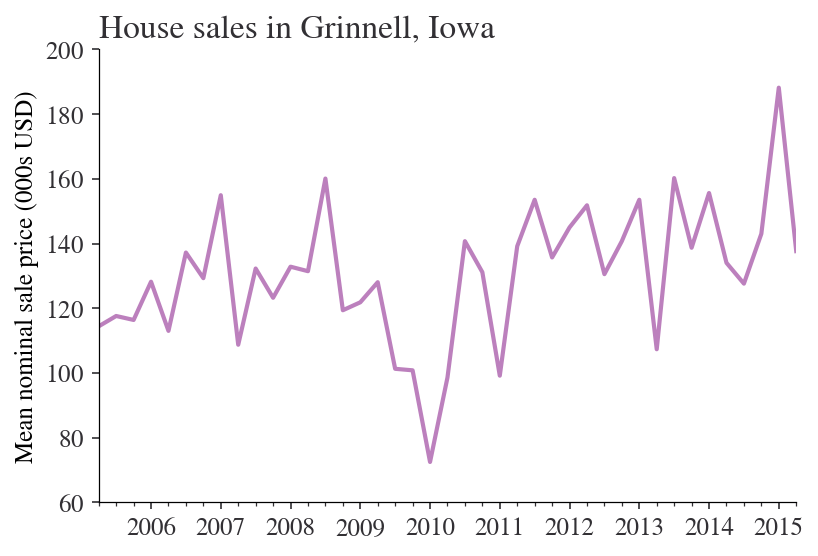

In [19]:
(
    df.set_index("datetime")
    .groupby(pd.Grouper(freq="3M"))["sale_price"]
    .mean()
    .apply(lambda x: x / 1e3)
    .plot(
        title="House sales in Grinnell, Iowa",
        xlabel="",
        ylabel="Mean nominal sale price (000s USD)",
    )
);

Again, if you can get the data in the right shape, you can plot it. The same function works with multiple lines


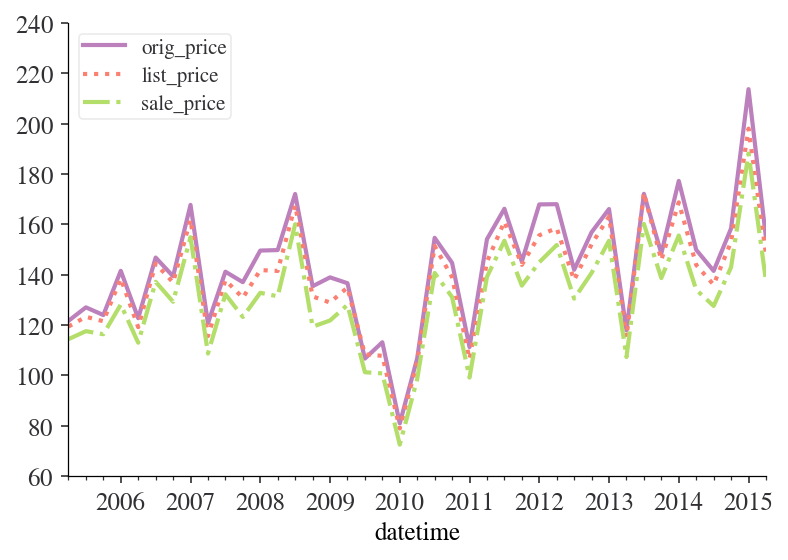

In [20]:
(
    df.set_index("datetime")
    .groupby(pd.Grouper(freq="3M"))[["orig_price", "list_price", "sale_price"]]
    .mean()
    .apply(lambda x: x / 1e3)
    .plot(style=["-", ":", "-."])
);

Now let's see some of the other quick `.plot.*` options.

Here's a kernel density estimation (KDE) plot. Just to show what's possible, we'll use the `df.columnname` syntax, an alternative to `df['columnname']`, and set limits via keyword arguments.

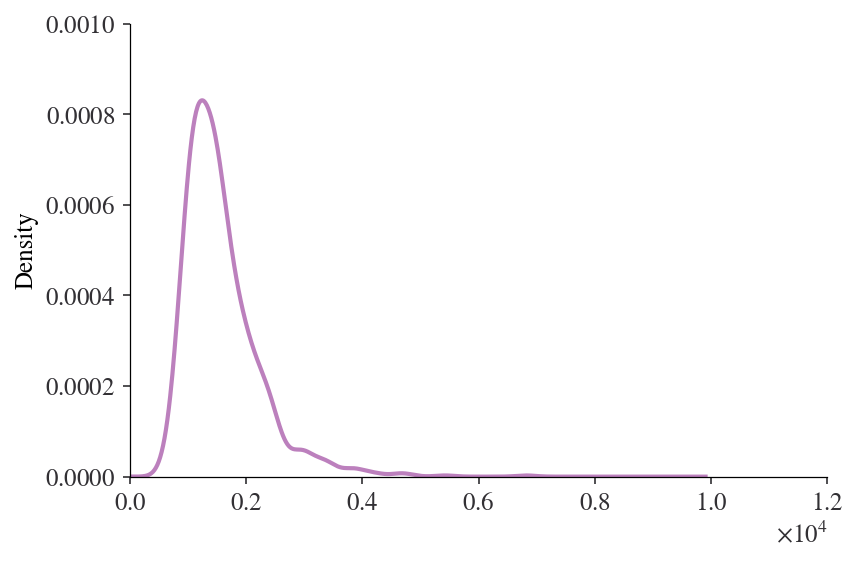

In [21]:
df.square_feet.plot.kde(ylim=(0, None), xlim=(0, None));

A bar chart (use `barh` for horizontal orientation; `rot` sets rotation of labels):

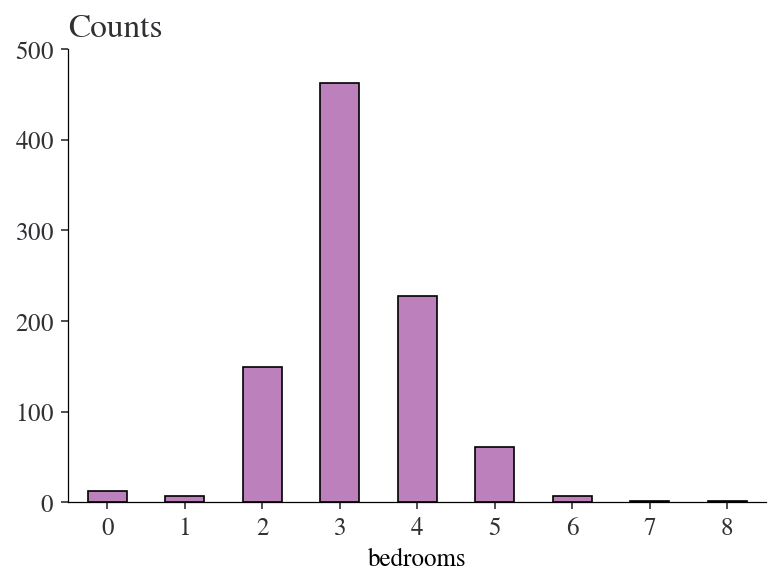

In [22]:
df.value_counts("bedrooms").sort_index().plot.bar(title="Counts", rot=0);

This chart shows why EDA is so important: if we are modelling residential housing, and we find that there are observations that don't have *any* bedrooms, perhaps they should be excluded from the downstream analysis.


This next one, using `.plot.hist`, provides another instructive example of how EDA can reveal interesting issues with datasets. First, there are many more houses built in 1900 than seem plausible and, checking the documentation for the dataset, it does say that when a construction date is not known, it is entered as 1900-which explains what's going on here. Second, some of the construction years are in the future! Is this plausible? It could be. Some houses are sold before the construction of an estate is completed; this could be the case here.

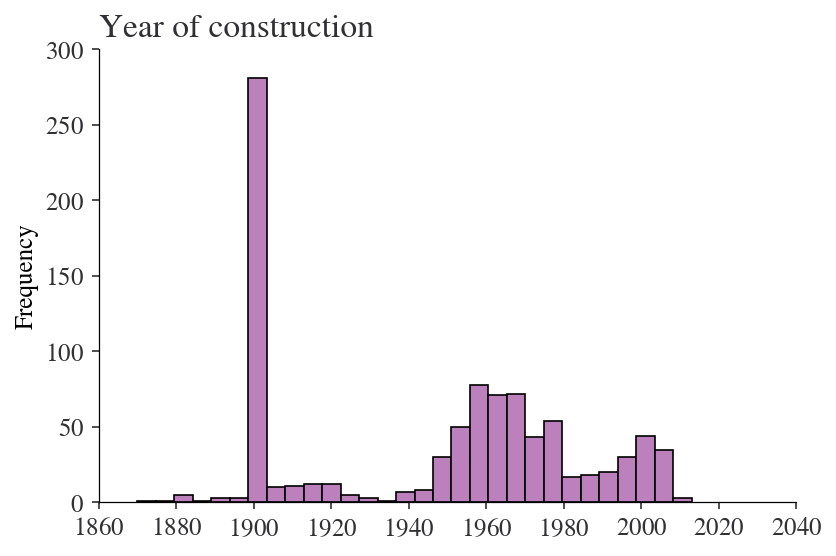

In [23]:
df["year_built"].plot.hist(bins=30, title="Year of construction");

Boxplot:

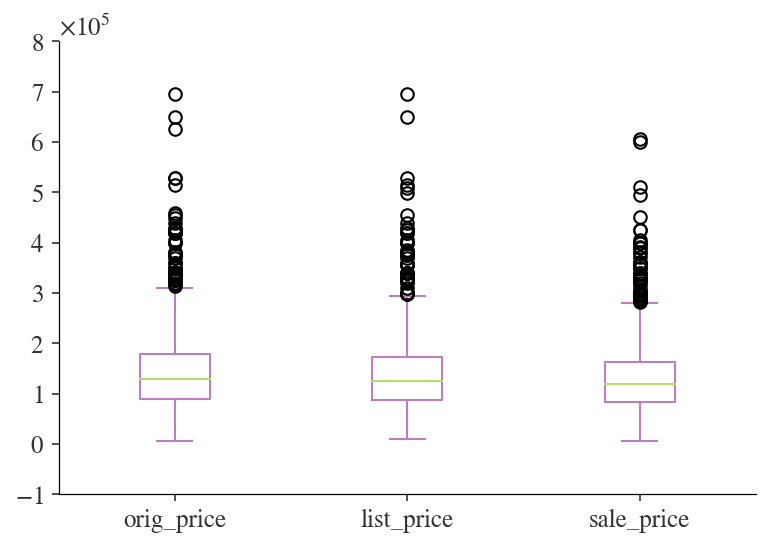

In [24]:
(df[["orig_price", "list_price", "sale_price"]].plot.box());

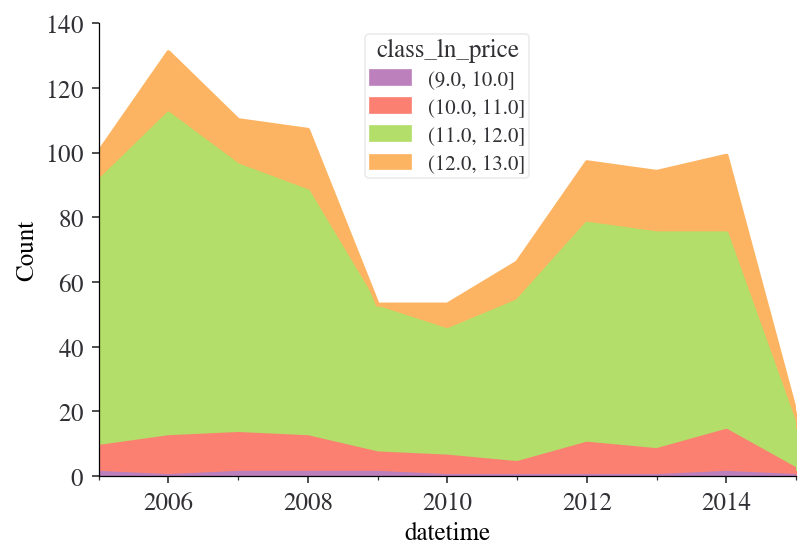

In [25]:
df["class_ln_price"] = pd.cut(np.log(df["orig_price"]), bins=4, precision=0)

(
    df.set_index("datetime")
    .groupby([pd.Grouper(freq="A"), "class_ln_price"])["class_ln_price"]
    .count()
    .unstack()
    .plot.area(ylabel="Count")
);

Scatter plot:

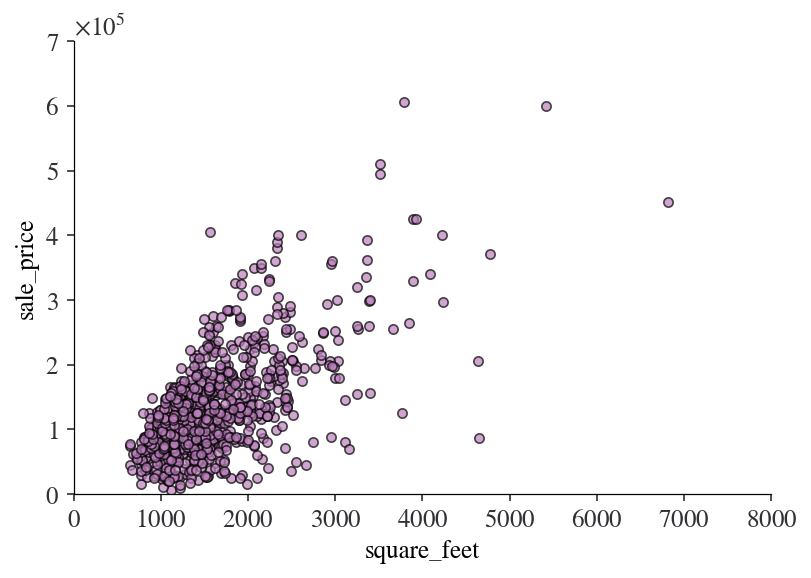

In [26]:
df.plot.scatter(x="square_feet", y="sale_price", alpha=0.7, ylim=(0, None));

Hexbin:

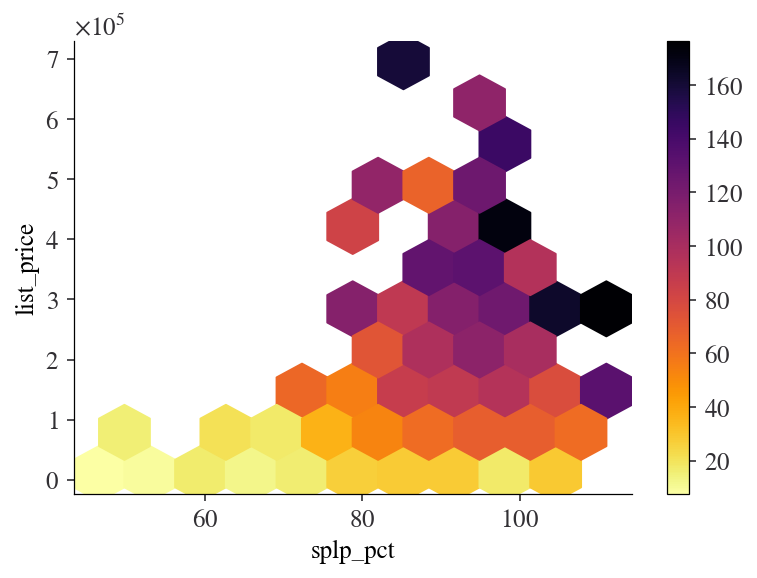

In [27]:
df.plot.hexbin(
    y="list_price",
    x="splp_pct",
    gridsize=10,
    cmap="inferno_r",
    C="cost_per_sq_ft",
    sharex=False,
);

## Light weight summary statistics with the **skimpy** package

The **skimpy** package is a light weight tool that provides summary statistics about variables in data frames in the console (rather than in a big HTML report, which is what the other EDA packages in the rest of this chapter too). Sometimes `df.summary()` isn't enough but a HTML report is too much, and **skimpy** fills this gap. Let's see it in action. (Full disclosure: I am the author of this package.)

In [28]:
from skimpy import skim

skim(df)

╭───────────────────────────────────── skimpy summary ──────────────────────────────────────╮
│          Data Summary                Data Types               Categories                  │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓ ┏━━━━━━━━━━━━━━━━━━━━━━━┓          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃ ┃ Categorical Variables ┃          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩ ┡━━━━━━━━━━━━━━━━━━━━━━━┩          │
│ │ Number of rows    │ 929    │ │ float64     │ 8     │ │ bedrooms              │          │
│ │ Number of columns │ 17     │ │ int64       │ 5     │ │ class_ln_price        │          │
│ └───────────────────┴────────┘ │ category    │ 2     │ └───────────────────────┘          │
│                                │ string      │ 1     │                                    │
│                                │ datetime64  │ 1     │                                    │
│                                └─────────────┴───────┘                                    │
│                                          number                                           │
│ ┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━━┳━━━━━━━┓  │
│ ┃        ┃ missin ┃ comple ┃ mean   ┃ sd     ┃ p0    ┃ p25    ┃ p75   ┃ p100   ┃ hist  ┃  │
│ ┃        ┃ g      ┃ te     ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┃        ┃        ┃ rate   ┃        ┃        ┃       ┃        ┃       ┃        ┃       ┃  │
│ ┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━━╇━━━━━━━┩  │
│ │ date   │ 0      │ 1.0    │ 18223. │ 1139.1 │ 16527 │ 17169. │ 19281 │ 20186. │ █▇▄▅▆ │  │
│ │        │        │        │ 22     │ 7      │ .0    │ 0      │ .0    │ 0      │       │  │
│ │ baths  │ 0      │ 1.0    │ 1.78   │ 0.74   │ 0.0   │ 1.0    │ 2.0   │ 6.0    │ ▄█▃   │  │
│ │ square │ 18     │ 0.98   │ 1583.2 │ 655.66 │ 640.0 │ 1150.0 │ 1833. │ 6815.0 │ █▂    │  │
│ │ _feet  │        │        │ 2      │        │       │        │ 0     │        │       │  │
│ │ lot_si │ 188    │ 0.8    │ 0.72   │ 2.73   │ 0.03  │ 0.23   │ 0.37  │ 55.0   │ █     │  │
│ │ ze     │        │        │        │        │       │        │       │        │       │  │
│ │ year_b │ 0      │ 1.0    │ 1945.9 │ 37.21  │ 1870. │ 1900.0 │ 1973. │ 2013.0 │  █▂█▄ │  │
│ │ uilt   │        │        │        │        │ 0     │        │ 0     │        │       │  │
│ │ year_s │ 0      │ 1.0    │ 2009.3 │ 3.12   │ 2005. │ 2007.0 │ 2012. │ 2015.0 │ ██▄▆▇ │  │
│ │ old    │        │        │ 7      │        │ 0     │        │ 0     │        │       │  │
│ │ month_ │ 0      │ 1.0    │ 6.83   │ 3.04   │ 1.0   │ 5.0    │ 9.0   │ 12.0   │ ▆▆█▇█ │  │
│ │ sold   │        │        │        │        │       │        │       │        │       │  │
│ │ day_so │ 0      │ 1.0    │ 16.23  │ 9.4    │ 1.0   │ 8.0    │ 25.0  │ 31.0   │ ▆▅▆▆█ │  │
│ │ ld     │        │        │        │        │       │        │       │        │       │  │
│ │ cost_p │ 0      │ 1.0    │ 83.29  │ 35.76  │ 0.0   │ 60.82  │ 105.7 │ 258.79 │ ▃█▄   │  │
│ │ er_sq_ │        │        │        │        │       │        │ 7     │        │       │  │
│ │ ft     │        │        │        │        │       │        │       │        │       │  │
│ │ orig_p │ 0      │ 1.0    │ 146047 │ 85174. │ 5990. │ 89900. │ 17900 │ 695000 │ █▄▁   │  │
│ │ rice   │        │        │ .08    │ 11     │ 0     │ 0      │ 0.0   │ .0     │       │  │
│ │ list_p │ 0      │ 1.0    │ 141399 │ 82228. │ 10500 │ 88000. │ 17200 │ 695000 │ █▄▁   │  │
│ │ rice   │        │        │ .14    │ 2      │ .0    │ 0      │ 0.0   │ .0     │       │  │
│ │ sale_p │ 0      │ 1.0    │ 133203 │ 77959. │ 7000. │ 83000. │ 16250 │ 606000 │ █▅▁   │  │
│ │ rice   │        │        │ .72    │ 62     │ 0     │ 0      │ 0.0   │ .0     │       │  │
│ │ splp_p │ 0      │ 1.0    │ 93.56  │ 6.95   │ 46.5  │ 91.32  │ 97.56 │ 111.02 │   ▁█▂ │  │
│ │ ct     │        │        │        │        │    

## The **pandas-profiling** package

The EDA we did using the built-in **pandas** functions was a bit limited and user-input heavy. The [**pandas-profiling**](https://pandas-profiling.github.io/pandas-profiling/docs/master/rtd/) library aims to automate the legwork of EDA for you. It generates 'profile' reports from a pandas DataFrame. For each column, many statistics are computed and then relayed in an interactive HTML report.

Let's generate a report on our dataset using the `minimal=True` setting (the default settings produce a lot of computationally expensive extras):

In [29]:
from pandas_profiling import ProfileReport


profile = ProfileReport(
    df, minimal=True, title="Profiling Report: Grinnell House Sales"
)
profile.to_notebook_iframe()

Render HTML: 100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


This is a full on report about everything in our dataset! We can see, for instance, that we have 17 numerical variables, 0 boolean, and 4 categorical (which includes string), and 1 datetime. The overview also tells us the number of observations, that we have 1.2% of values missing across all columns, and we have zero duplicates.

The warnings page shows where **pandas-profiling** really shines. It flags *potential* issues with the data that should be taken into account in any subsequent analysis. For example, although not relevant here, the report will say if there are very unbalanced classes in a low cardinality categorical variable.

Let's explore a couple of the warnings that have been raised. `Address` has high cardinality; but that's okay, we expect most addresses to be different because the turn-over of houses is not that frequent. We also see that there are a lot of missing values for `LotSize`.

Now let's dig down into a specific variable, `SalePrice`. You can view more about it using the 'Toggle details' button. We get four extra pages of detail about this variable, in addition to the headline statistics: a comprehensive page of descriptive statistics, a page with a histogram of the variable, a page with a table of common values, and a page of extreme values.

## The **dataprep** package

The [**dataprep**](https://dataprep.ai/) package offers very similar functionality to **pandas-profiling**; it produces an in-depth report on the input data. There isn't much difference between them in general apart from it seems like **dataprep** has slightly better support for string column types (check out the details of `Address` below) and is a little bit richer on visualisations (it has interactive plots that you can change the axes of-look at the interactions page below).

Do note, however, that some column types can create an error-which is why we'll pass in all but the last column of our dataframe from the previous set of examples. In this case, having a bin-category column seems to be an issue.

In [30]:
from dataprep.eda import create_report

report = create_report(df.iloc[:, 2:-1])

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/o

  0%|          | 0/2394 [00:00<?, ?it/s]

/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/opt/anaconda3/envs/codeforecon/lib/python3.8/site-packages/dask/utils.py:893: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  return getattr(obj, self.method)(*args, **kwargs)
/Users/aet/o

DataPrep Report
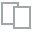
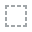
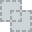
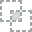
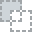
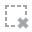
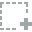
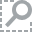
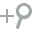
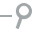
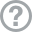
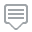
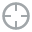
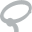
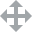
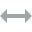
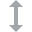
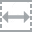
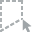
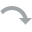
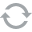
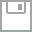
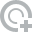
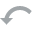
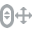
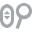
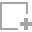
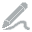
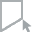
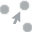
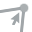
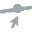

In [31]:
from IPython.core.display import display


display(report)

## Review

That's it for this very brief tour of exploratory data analysis with code. You should know now how to do simple analysis of **pandas** dataframes using techniques from other chapters to create summary statistics, using styling of tables of summary statistics, and using the quick visualisation options that are built-in to **pandas**. You should also know where to go for more in-depth, heavy duty exploratory data analysis reports, namely **pandas-profiling** and **dataprep**.